In [1]:
import datetime
import json
import boto3
import io
import pickle
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [37]:
DF_COLUMNS = [
    "datetime",
    "cash",
    "cash_orig",
    "btc_in_possession",
    "btc_current_price",
    "position",
    "rate_of_change",
    "total_value",
    "acceleration",
    "bid_high",
    "ask_low",
    "mid_price",
    "bought_price",
    "sold_price",
    "ask_price",
    "target_profit",
    "size"
]
BUCKET_NAME = 'btc-autotrader-log'
DATE = '2019-05-20'

In [53]:
session = boto3.session.Session(profile_name='soujiro0725')
s3 = session.client('s3')

In [47]:
list_objects_response = s3.list_objects(
    Bucket=BUCKET_NAME,
    Prefix=DATE
)

keys = []
for l in list_objects_response['Contents']:
    keys.append(l['Key'])

In [100]:
merged = pd.DataFrame(columns=DF_COLUMNS)

for k in keys:
    obj = s3.get_object(
        Bucket=BUCKET_NAME,
        Key=k
    )
    o = obj['Body'].read()
    #merged = pd.merge(merged, pickle.loads(o))
    merged = merged.append(pickle.loads(o))

In [103]:
df = merged

In [104]:
df.head()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,mid_price,bought_price,sold_price,ask_price,target_profit,size
0,2019-05-20 08:02:04.252370,0.0,0,0.0,0.0,0,0.000000,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
0,2019-05-20 08:02:09.263332,0.0,0,0.0,903500.0,0,8.336857,0,0.000000,903499.0,903500.0,903499.0,0.0,0.0,0.0,0,0
0,2019-05-20 08:02:14.251867,0.0,0,0.0,903596.0,0,14.146389,0,1.155996,903597.0,904000.0,903798.0,0.0,0.0,0.0,0,0
0,2019-05-20 08:02:19.276837,0.0,0,0.0,904053.0,0,26.547796,0,2.485151,903657.0,904150.0,903903.0,0.0,0.0,0.0,0,0
0,2019-05-20 08:02:24.305291,0.0,0,0.0,904149.0,0,38.753823,0,2.426712,903657.0,904149.0,903903.0,0.0,0.0,0.0,0,0


In [105]:
df['spread'] = df.ask_low - df.bid_high

In [106]:
df['spread_pct_change'] = df.spread.pct_change()

In [107]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [108]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [109]:
df['returns'] = np.log(df['btc_current_price']/df['btc_current_price'].shift(1))

/Users/sishida/.pyenv/versions/3.7.1/envs/finance-stats/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [110]:
df['strategy'] = df['rate_of_change_positive'].shift(1) * df['returns']

In [111]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,sold_price,ask_price,target_profit,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-05-20 12:34:38.086887,42525.0,0,0.008631,881500.0,0,5.865379,0,0.097930,881070.0,...,0.0,0.0,0,0,430.0,-0.022727,2.0,-0.03818,0.0,0.0
0,2019-05-20 12:34:43.111447,42525.0,0,0.008631,881500.0,0,6.321713,0,0.090766,881070.0,...,0.0,0.0,0,0,430.0,0.000000,2.0,-0.03818,0.0,0.0
0,2019-05-20 12:34:48.127414,42525.0,0,0.008631,881500.0,0,6.651415,0,0.065606,881060.0,...,0.0,0.0,0,0,440.0,0.023256,2.0,-0.03818,0.0,0.0
0,2019-05-20 12:34:53.156674,42525.0,0,0.008631,881500.0,0,7.161381,0,0.101571,881061.0,...,0.0,0.0,0,0,439.0,-0.002273,2.0,-0.03818,0.0,0.0
0,2019-05-20 12:34:58.141826,42525.0,0,0.008631,881500.0,0,7.726893,0,0.113336,881061.0,...,0.0,0.0,0,0,439.0,0.000000,2.0,-0.03818,0.0,0.0


In [112]:
np.exp(df[['returns', 'strategy']].sum())

returns    NaN
strategy   NaN
dtype: float64

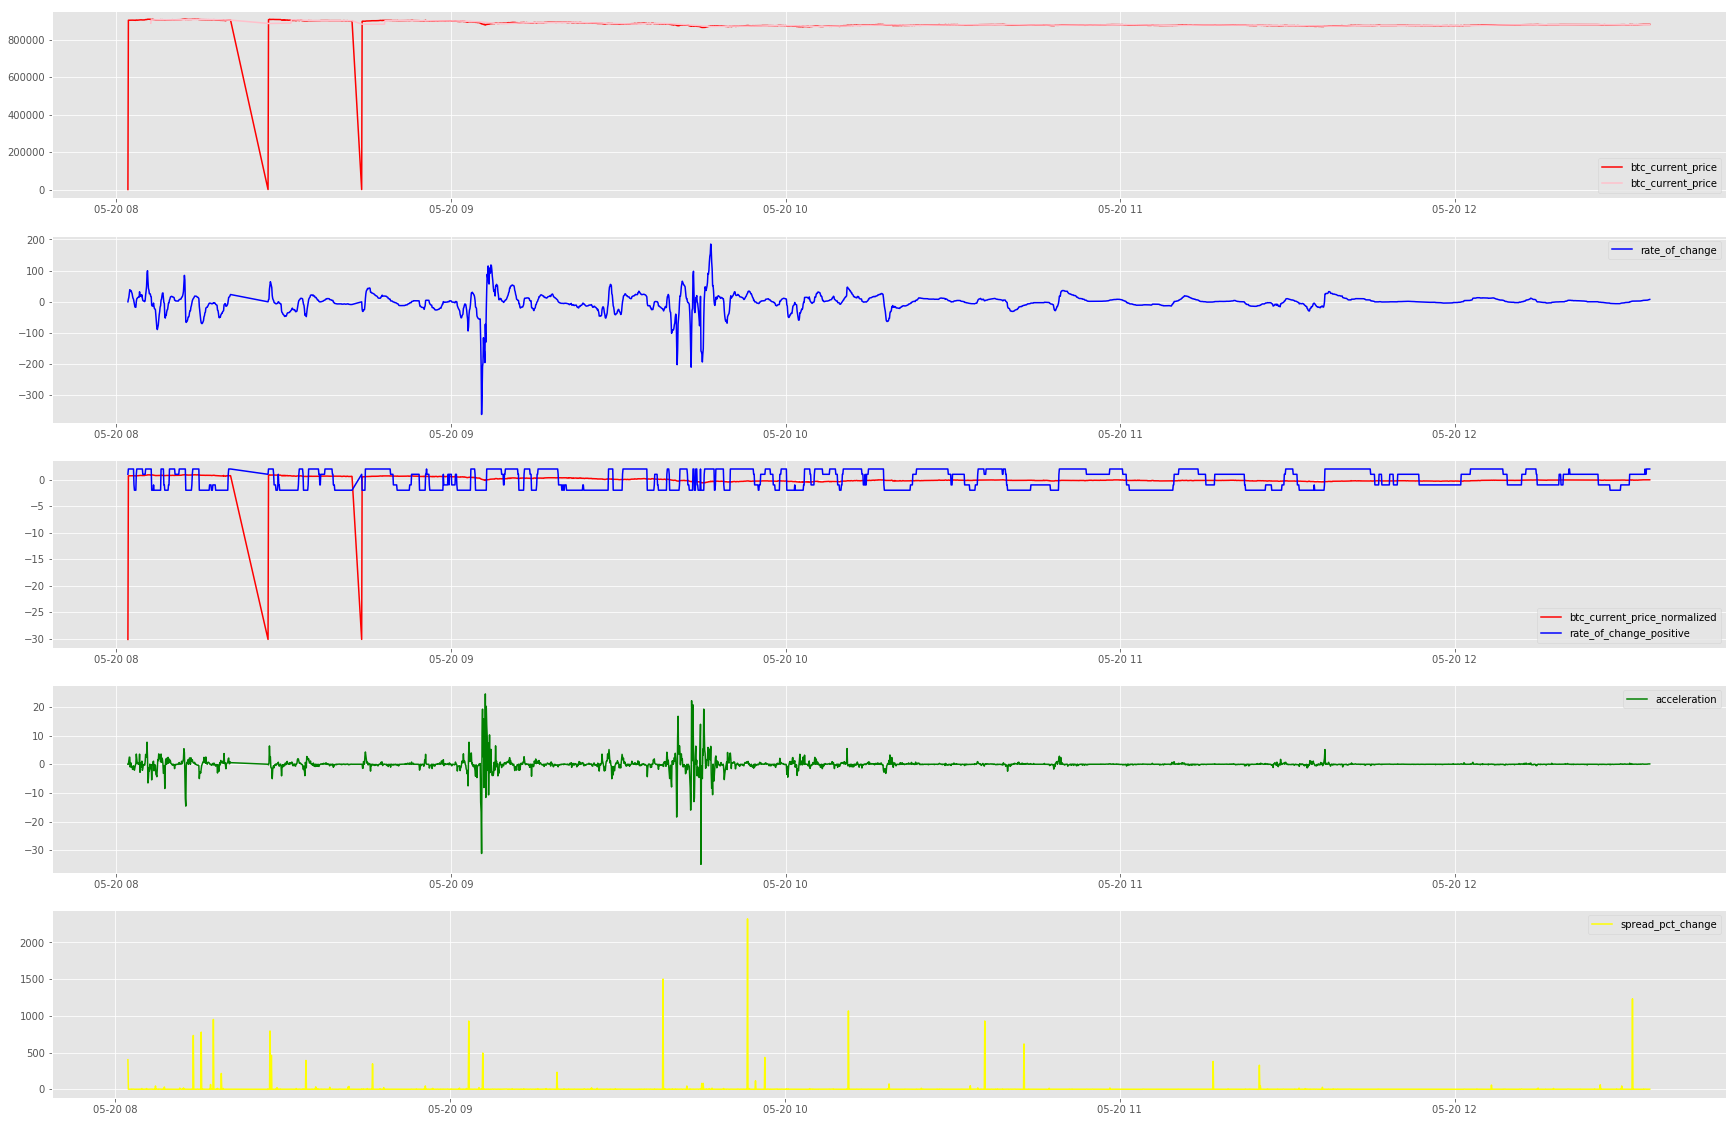

In [113]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

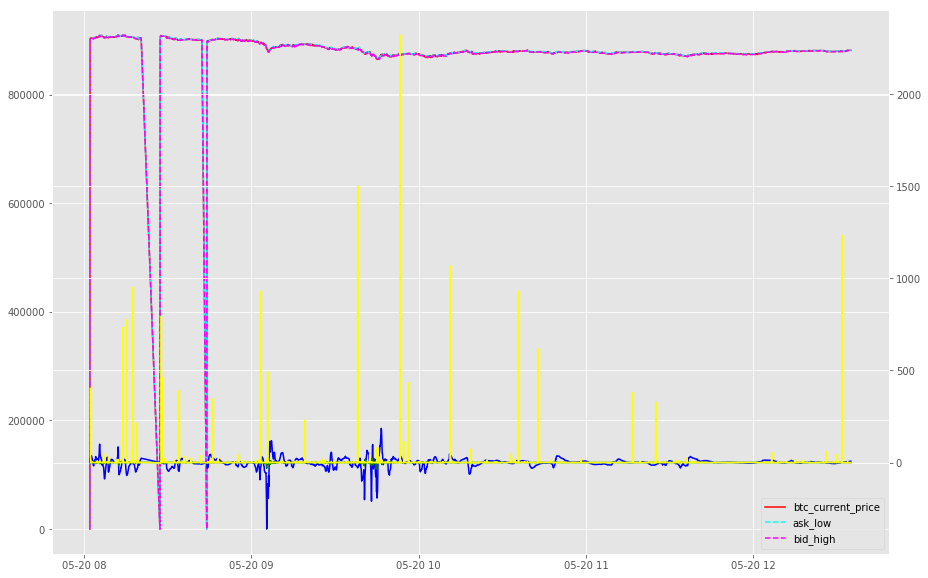

In [114]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

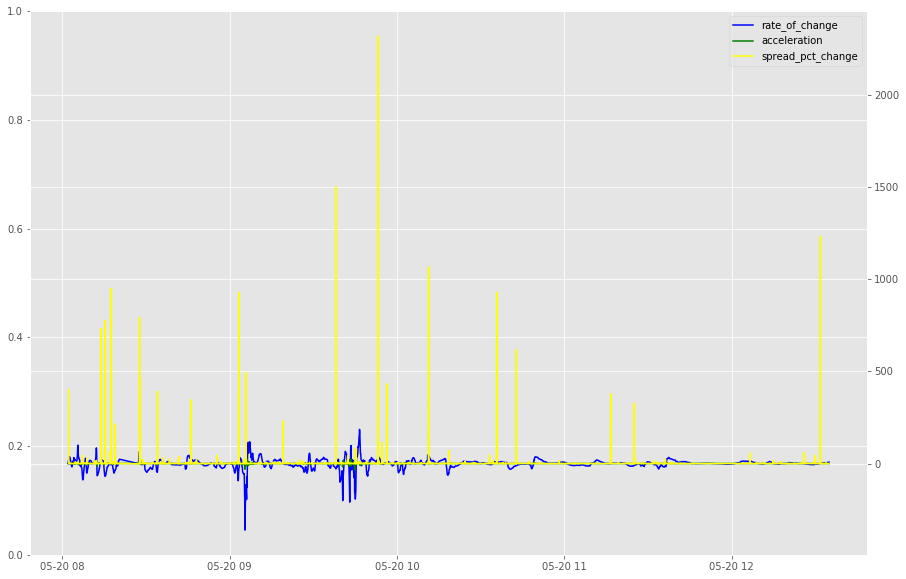

In [115]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

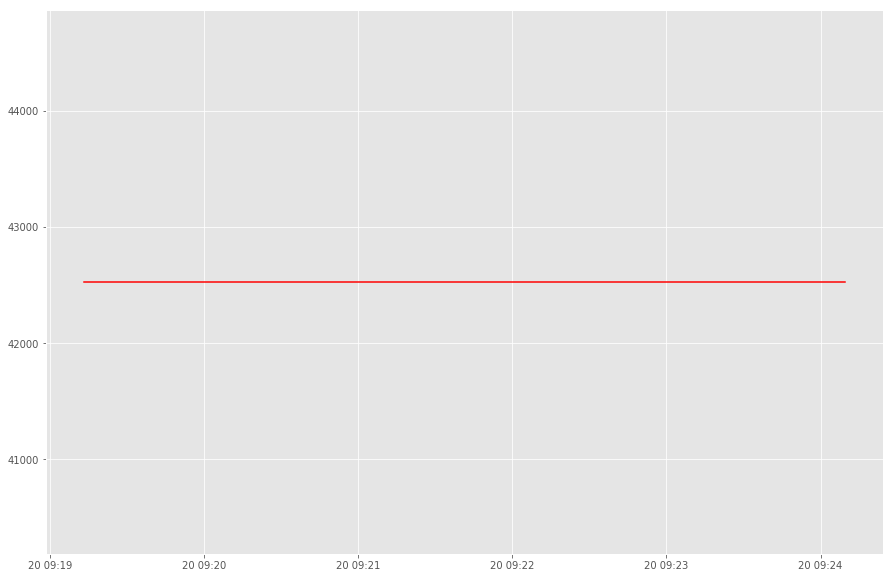

In [20]:
df_cash = df[df.position == 0]
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(df_cash.datetime, df_cash.cash, color='r')

In [34]:
df

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,sold_price,ask_price,target_profit,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-04-25 08:00:03.848380,42539.0,0,0.008679,611500.0,0,1.268062,0,None,611500.0,...,0,0,100,0,287.0,NaN,1.0,0.914810,NaN,NaN
0,2019-04-25 08:00:08.865314,42539.0,0,0.008679,611500.0,0,1.269854,0,0.000177887,611500.0,...,0,0,100,0,287.0,0.000000,1.0,0.914810,0.000000,0.000000
0,2019-04-25 08:00:13.879647,42539.0,0,0.008679,611787.0,0,1.269854,0,0.000177887,611500.0,...,0,0,100,0,285.0,-0.006969,1.0,1.238483,0.000469,0.000469
0,2019-04-25 08:00:18.895399,36421.0,0,0.018667,611785.0,2,1.289793,0,0.00397114,611500.0,...,0,611885,100,0,285.0,0.000000,1.0,1.236227,-0.000003,-0.000003
0,2019-04-25 08:00:23.920676,36421.0,0,0.018667,611785.0,3,1.308728,0,0.00376852,611500.0,...,0,611885,100,0,284.0,-0.003509,1.0,1.236227,0.000000,0.000000
0,2019-04-25 08:00:28.943152,36421.0,0,0.008655,611784.0,3,1.308728,0,0,611500.0,...,0,611886,101,0,283.0,-0.003521,1.0,1.235099,-0.000002,-0.000002
0,2019-04-25 08:00:33.968807,36421.0,0,0.018667,611784.0,3,1.326805,0,0.00359715,611500.0,...,0,611887,102,0,283.0,0.000000,1.0,1.235099,0.000000,0.000000
0,2019-04-25 08:00:38.992168,36421.0,0,0.008655,611784.0,3,1.326805,0,0,611500.0,...,0,611888,103,0,283.0,0.000000,1.0,1.235099,0.000000,0.000000
0,2019-04-25 08:00:44.017061,36421.0,0,0.018667,611783.0,3,1.326805,0,0,611500.0,...,0,611889,104,0,285.0,0.007067,1.0,1.233972,-0.000002,-0.000002
0,2019-04-25 08:00:49.040997,36421.0,0,0.018667,611783.0,3,1.343203,0,0.00326282,611500.0,...,0,611890,105,0,284.0,-0.003509,1.0,1.233972,0.000000,0.000000
